In [1]:
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from os.path import join, isdir, dirname, abspath
from os import listdir
from typing import List
from pathlib import Path
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from collections import OrderedDict
import torch
from scipy.stats import linregress

from matplotlib import colors


root_path = dirname(abspath("./"))
import sys
sys.path.append(root_path)

from prochain_transformer.subroutines.eval_sweeps import get_df_recursive, has_logs_subfolder, get_df_kfold_loss
from prochain_transformer.predict import get_features_gradients
from prochain_transformer.modules.utils import find_last_checkpoint
from prochain_transformer.experiment_control import update_config
from prochain_transformer.forecaster import TransformerForecaster

In [50]:
def post_process_sweep(
    df: pd.DataFrame,
    compound_cols: List[dict],
    columns_name_map: dict=None,
    columns_to_dump: list=None
    ):
    
    df_ = df.copy()
    
    # extract sweeps and base info
    for compound_col in compound_cols:
        df_[compound_col["new_label"]] = df_[compound_col["old_label"]].str.extract(compound_col["regex"])
        df_[compound_col["new_label"]] = df_[compound_col["new_label"]].astype(compound_col["type"])
        
    if columns_name_map is not None:
        df_ = df_.rename(columns=columns_name_map)
        
    if columns_to_dump is not None:
        df_ = df_.drop(columns=columns_to_dump)
        
    return df_


def get_heat_data(df, sample_id: str, values_label):
    
    df_ = df.copy()
    x_label = "model base"
    y_label = "embedding base"
    id_column = ["sweep variable", "feature"]
    
    
    df_sub = df_.set_index(id_column).loc[sample_id]
    x_order = sorted(df_sub[x_label].unique())   # ascending
    y_order = sorted(df_sub[y_label].unique())   # ascending

    # build the matrix and re-index to those order
    heat = (
        df_sub
        .pivot_table(
            index=y_label,
            columns=x_label,
            values=values_label,
            #aggfunc="mean"
            )          # or any reducer you need
        .reindex(index=y_order, columns=x_order)
    )
    return heat

In [51]:
# load sensitivity dataframe
df_sens = pd.read_csv("../experiments/evaluations/dx_250618_cat/sensitivity/df_S")

# load loss dataframe
dirpath = "../experiments/training/dx_250618_cat"
df_loss = get_df_recursive(filepath=dirpath, bottom_action=get_df_kfold_loss, is_bottom= has_logs_subfolder)


columns_name_map_sens = {
    "feat0"  : "variable",
    "feat1"  : "position",
    "feat2"  : "value",
    "feat3"  : "time",
    "level_2": "sweep variable"
    }

columns_name_map_loss = {
    "val_loss"  : "validation",
    "train_loss"  : "train",
    "test_loss"  : "test",
    "level_2": "sweep variable"
    }

compound_cols_sens = [
        {
            "old_label":"level_3", 
            "new_label":"sweep value", 
            "regex":r"(\d+)$", 
            "type":float
            },
        {
            "old_label" :"level_0",
            "new_label": ["embedding base", "model base"],
            "regex":r"^emb(\d+)_mod(\d+)$", 
            "type":float}
        ]

compound_cols_loss = [
        {
            "old_label":"level_3", 
            "new_label":"sweep value", 
            "regex":r"(\d+)$", 
            "type":float
            },
        {
            "old_label" :"level_0",
            "new_label": ["embedding base", "model base"],
            "regex":r"^emb(\d+)_mod(\d+)$",  
            "type":float}
        ]

columns_to_dump = [
    "level_0",
    "level_1",
    "level_3"
]



df_S = post_process_sweep(df_sens, compound_cols_sens, columns_name_map_sens,columns_to_dump)
df_L = post_process_sweep(df_loss, compound_cols_loss, columns_name_map_loss, columns_to_dump)

# merge dataframes
index_columns = ["model base", "embedding base", "sweep variable", "sweep value", "k"]
df = pd.merge(df_L, df_S, on=index_columns, how='inner')
df.head()

,k,validation,train,test,sweep variable,sweep value,embedding base,model base,Unnamed: 0,variable,position,value,time
0,k_0,0.019837,0.012787,0.015421,sweep_dec_pos_emb_hidden,0.0,100.0,100.0,0,0.012604,0.017624,0.017759,0.003657
1,k_1,0.016939,0.011716,0.015905,sweep_dec_pos_emb_hidden,0.0,100.0,100.0,1,0.004257,0.005641,0.005749,0.001990
2,k_2,0.020446,0.012502,0.016387,sweep_dec_pos_emb_hidden,0.0,100.0,100.0,2,0.008928,0.007212,0.014089,0.003496
3,k_3,0.019095,0.011104,0.019214,sweep_dec_pos_emb_hidden,0.0,100.0,100.0,3,0.003144,0.002775,0.002320,0.001426
4,k_4,0.023517,0.011221,0.023411,sweep_dec_pos_emb_hidden,0.0,100.0,100.0,4,0.004006,0.002705,0.002133,0.001175


In [52]:
df_test = df.set_index(["embedding base", "model base","sweep variable"]).loc[20].loc[20].loc["sweep_enc_pos_emb_hidden"].fillna(value=0)
df_test.head()

,k,validation,train,test,sweep value,Unnamed: 0,variable,position,value,time
sweep variable,,,,,,,,,,
sweep_enc_pos_emb_hidden,k_0,0.008148,0.000468,0.001081,0.0,0,0.000762,0.0,0.003131,0.000245
sweep_enc_pos_emb_hidden,k_1,0.005992,0.000211,0.001398,0.0,1,0.000877,0.0,0.000590,0.000319
sweep_enc_pos_emb_hidden,k_2,0.008475,0.000353,0.002530,0.0,2,0.001025,0.0,0.000505,0.000359
sweep_enc_pos_emb_hidden,k_3,0.007244,0.000177,0.002271,0.0,3,0.002298,0.0,0.006050,0.000912
sweep_enc_pos_emb_hidden,k_4,0.007704,0.000457,0.011201,0.0,4,0.001815,0.0,0.002788,0.000693


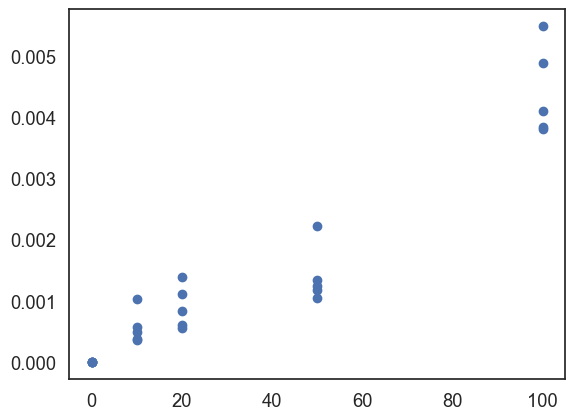

In [53]:
plt.scatter(df_test["sweep value"], df_test["position"])

In [59]:
value_vars_loss = ["train","test","validation"]
id_vars_loss = [x for x in df.columns.tolist() if x not in value_vars_loss]
df_loss_melt = df.melt(id_vars=id_vars_loss, value_vars=value_vars_loss, var_name="dataset", value_name="loss")


value_vars_cols = ["variable","position","value","time"]
id_vars_cols = [x for x in df.columns.tolist() if x not in value_vars_cols]
df_melt = df.melt(id_vars=id_vars_cols, value_vars=value_vars_cols, var_name="feature", value_name="sensitivity")
df_melt

,k,validation,train,test,sweep variable,sweep value,embedding base,model base,Unnamed: 0,feature,sensitivity
0,k_0,0.019837,0.012787,0.015421,sweep_dec_pos_emb_hidden,0.0,100.0,100.0,0,variable,0.012604
1,k_1,0.016939,0.011716,0.015905,sweep_dec_pos_emb_hidden,0.0,100.0,100.0,1,variable,0.004257
2,k_2,0.020446,0.012502,0.016387,sweep_dec_pos_emb_hidden,0.0,100.0,100.0,2,variable,0.008928
3,k_3,0.019095,0.011104,0.019214,sweep_dec_pos_emb_hidden,0.0,100.0,100.0,3,variable,0.003144
4,k_4,0.023517,0.011221,0.023411,sweep_dec_pos_emb_hidden,0.0,100.0,100.0,4,variable,0.004006
...,...,...,...,...,...,...,...,...,...,...,...
8635,k_0,0.009664,0.000975,0.002996,sweep_enc_var_emb_hidden,50.0,50.0,50.0,0,time,0.001012
8636,k_1,0.008147,0.000892,0.001717,sweep_enc_var_emb_hidden,50.0,50.0,50.0,1,time,0.001018
8637,k_2,0.016564,0.002946,0.007671,sweep_enc_var_emb_hidden,50.0,50.0,50.0,2,time,0.000882
8638,k_3,0.006612,0.000113,0.000851,sweep_enc_var_emb_hidden,50.0,50.0,50.0,3,time,0.001435


In [55]:
def fit_slope(group):
    x = group["sweep value"].fillna(0)
    y = group["sensitivity"].fillna(0)
    res = linregress(x, y)
    return pd.Series({"coef": res.slope, "stderr": res.stderr})


slopes = df_melt.groupby(["sweep variable",'feature', 'model base', 'embedding base', "k"])[['sweep value','sensitivity']].apply(fit_slope).reset_index()

# calculate std from k-fold
cell_stats = slopes.groupby(["sweep variable", "feature", "model base", "embedding base"]).agg(
    coef = ("coef", "mean"),
    stderr = ("coef", "std")).reset_index()

cell_stats.head()

,sweep variable,feature,model base,embedding base,coef,stderr
0,sweep_d_ff,position,20.0,20.0,-0.000007,0.000004
1,sweep_d_ff,position,20.0,50.0,0.000009,0.000014
2,sweep_d_ff,position,20.0,100.0,-0.000033,0.000068
3,sweep_d_ff,position,50.0,20.0,-0.000006,0.000004
4,sweep_d_ff,position,50.0,50.0,-0.000004,0.000006


In [56]:
sweep_feat_pairs = [
    ("sweep_enc_pos_emb_hidden","position"),
    ("sweep_enc_var_emb_hidden","variable"),
    ("sweep_enc_val_emb_hidden","value"),
    ("sweep_enc_time_emb_hidden","time")
    
]

cell_stats.set_index(["sweep variable", "feature"]).loc[sweep_feat_pairs[0]]

model base  embedding base      coef  \
sweep variable           feature                                          
sweep_enc_pos_emb_hidden position        20.0            20.0  0.000042   
                         position        20.0            50.0  0.000040   
                         position        20.0           100.0  0.000052   
                         position        50.0            20.0  0.000042   
                         position        50.0            50.0  0.000057   
                         position        50.0           100.0  0.000082   
                         position       100.0            20.0  0.000063   
                         position       100.0            50.0  0.000070   
                         position       100.0           100.0  0.000081   

                                     stderr  
sweep variable           feature             
sweep_enc_pos_emb_hidden position  0.000007  
                         position  0.000003  
                         position  0.000029  
                         position  0.000026  
                         position  0.000029  
                         position  0.000054  
                         position  0.000029  
                         position  0.000026  
                         position  0.000115

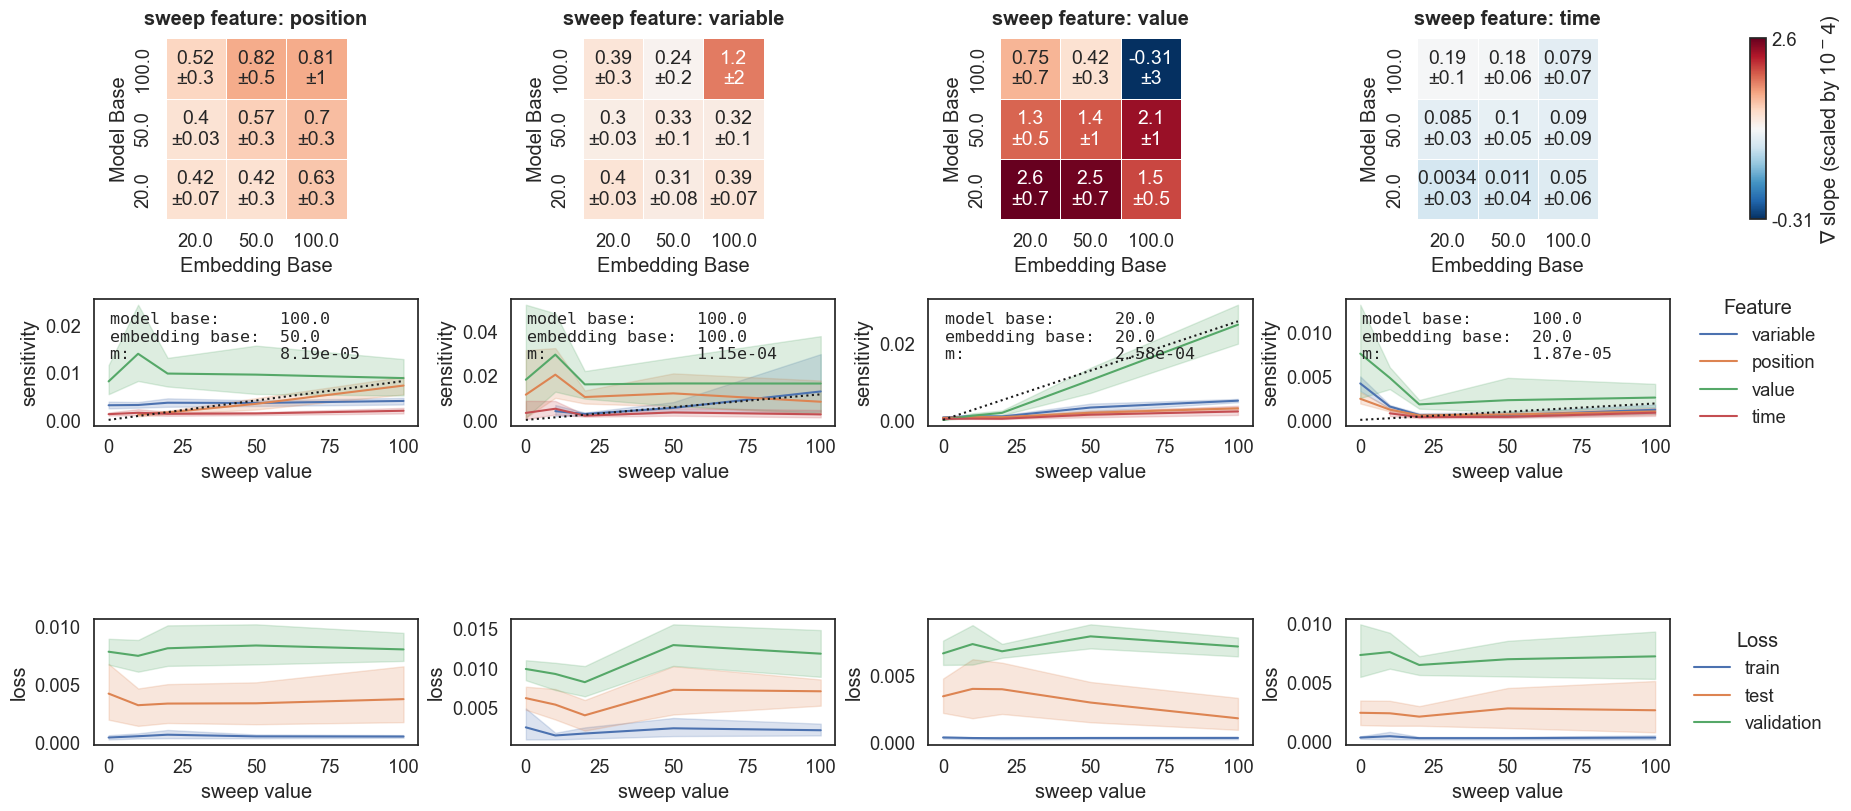

In [68]:
sns.set_theme(style="white", font_scale=1.2)

num_vars = len(sweep_feat_pairs)
fig = plt.figure(figsize=(num_vars*4.6, 8), constrained_layout=True)

gs  = GridSpec(
    4, 
    num_vars+1, 
    figure=fig,
    width_ratios=[*([1]*num_vars), .05],
    height_ratios=[1, .7, .7, .7]
    )

palettes  = ["RdBu_r", "PuOr", "BrBG", "PiYG"]

abs_max  = np.nanmax(cell_stats["coef"])
exp10  = int(np.floor(np.log10(abs_max)))
scale  = 10**exp10
#scale = abs_max

vmin, vmax = 0,0

for i, var in enumerate(sweep_feat_pairs):
    heat_data = get_heat_data(cell_stats, var, "coef")
    lmax, lmin = heat_data.values.max(), heat_data.values.min()
    if lmax > vmax:
        vmax = lmax
    if lmin < vmin:
        vmin = lmin

vmax, vmin = vmax/scale, vmin/scale


norm = colors.PowerNorm(gamma=0.4, vmin=vmin, vmax=vmax)


for i, var in enumerate(sweep_feat_pairs):
    # ---------- HEAT-MAP ----------
    ax = fig.add_subplot(gs[0,i])

    heat_data = get_heat_data(cell_stats, var, "coef")/scale
    heat_std = get_heat_data(cell_stats, var, "stderr")/scale
    
    group_max = heat_data.stack().idxmax() # (model base, embedding base)
    group_min = heat_data.stack().idxmin() # (model base, embedding base)
    
    fmt = np.vectorize(lambda b, s: f"{b:.2g}\n±{s:.1g}")

    annot = fmt(heat_data.values, heat_std.values)
    
    hm = sns.heatmap(
        heat_data,
        cmap=palettes[0],
        norm=norm,
        square=True,
        linewidths=.4, linecolor="white",
        cbar=False,          # ← colour-bar removed
        ax=ax,
        annot=annot,          # ← show values
        fmt="",           # number format (e.g. 2 decimals)
        annot_kws={"size":14},
    )
    ax.invert_yaxis()
    ax.set_title(f"sweep feature: {var[-1]}", pad=10, weight="bold")

    ax.set_ylabel("Model Base")
    ax.set_xlabel("Embedding Base")
    
    # ---------- LINE-PLOT ----------
    ax1 = fig.add_subplot(gs[1,i])
    df_lplot = df_melt.set_index(["sweep variable","model base","embedding base"]).loc[var[0]].loc[group_max[0]].loc[group_max[1]].reset_index()
    sns.lineplot(df_lplot, x="sweep value", y="sensitivity", hue="feature", ax=ax1)
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend().remove()
    
    coeff = get_heat_data(cell_stats, var, "coef").max(axis=None)
    x = np.array([0, 25, 50, 75, 100])
    ax1.plot(x,x*coeff, color="k", linestyle=":")
    
    text = (
    f"{'model base:':<16} {group_max[0]}\n"
    f"{'embedding base:':<16} {group_max[1]}\n"
    f"{'m:':<16} {coeff:.2e}"
    )

    ax1.text(0.05, 0.9, text,
            transform=ax1.transAxes,
            fontsize=12,
            fontfamily='monospace',
            ha='left', va='top')
    
    # # ---------- LINE-PLOT ----------
    # ax1_1 = fig.add_subplot(gs[2,i])
    # df_lplot = df_melt.set_index(["sweep variable","model base","embedding base"]).loc[var[0]].loc[50].loc[50].reset_index()
    # sns.lineplot(df_lplot, x="sweep value", y="sensitivity", hue="feature", ax=ax1_1)
    # ax1_1.legend().remove()
    
    # ---------- LINE-PLOT ----------
    ax2 = fig.add_subplot(gs[-1,i])
    df_lplot = df_loss_melt.set_index(["sweep variable","model base","embedding base"]).loc[var[0]].loc[group_max[0]].loc[group_max[1]].reset_index()
    sns.lineplot(df_lplot, x="sweep value", y="loss", hue="dataset", ax=ax2)
    handles_loss, labels_loss = ax2.get_legend_handles_labels()
    ax2.legend().remove()
    
    

sm  = mpl.cm.ScalarMappable(norm=norm, cmap=palettes[0])
cax = fig.add_subplot(gs[0,-1])


scale_label  = rf"$\nabla$ slope (scaled by 10$^{exp10}$)"

fmt = lambda x: f"{x:.2g}" 

cbar = fig.colorbar(sm, cax=cax, label=scale_label, ticks=[vmin, vmax])
cbar.set_ticklabels([fmt(vmin), fmt(vmax)])
cbar.ax.tick_params(size=0) 


ax_leg = fig.add_subplot(gs[1, -1])
ax_leg.axis("off")                          # no ticks / frame

# now draw the legend there
ax_leg.legend(
    handles, labels,
    ncol=1,
    loc="center",
    frameon=False,
    title="Feature",
    borderpad=0.8,            # fine-tune spacing
    handlelength=2.0
)

ax_leg_loss = fig.add_subplot(gs[-1, -1])
ax_leg_loss.axis("off")                          # no ticks / frame

# now draw the legend there
ax_leg_loss.legend(
    handles_loss, labels_loss,
    ncol=1,
    loc="center",
    frameon=False,
    title="Loss",
    borderpad=0.8,            # fine-tune spacing
    handlelength=2.0
)

plt.show()

In [58]:
df["sweep variable"].unique()

array(['sweep_dec_pos_emb_hidden', 'sweep_dec_time_emb_hidden',
       'sweep_dec_val_emb_hidden', 'sweep_dec_var_emb_hidden',
       'sweep_d_ff', 'sweep_d_qk', 'sweep_enc_pos_emb_hidden',
       'sweep_enc_time_emb_hidden', 'sweep_enc_val_emb_hidden',
       'sweep_enc_var_emb_hidden'], dtype=object)

<Axes: xlabel='sweep value', ylabel='sensitivity'>

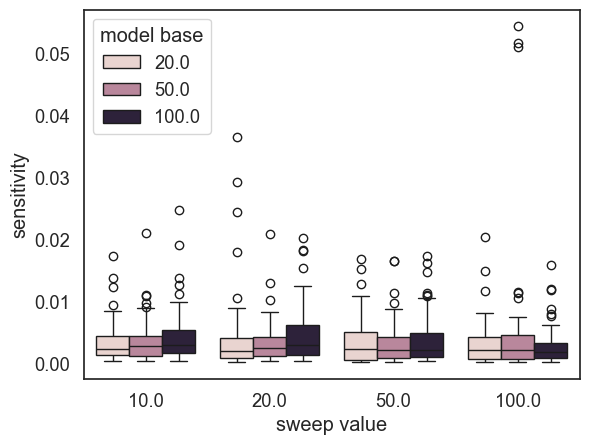

In [ ]:
df_plot = df_melt.set_index(["sweep variable"]).loc["sweep_d_ff"].fillna(value=0)

sns.boxplot(df_plot, x="sweep value",y="sensitivity", hue="model base")